In [1]:
import pickle
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt   
import os

In [13]:
data_dict = pickle.load(open("../dataset/full_asl_dataset.pickle", 'rb'))

In [2]:
expected_length = 84
filtered_data = []
filtered_labels = []

In [4]:
for sample, label in zip(data_dict['data'], data_dict['labels']):
    if len(sample) == expected_length:
        filtered_data.append(sample)
        filtered_labels.append(label)

data = np.asarray(filtered_data, dtype=np.float32)
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(filtered_labels)

labels = np.asarray(encoded_labels, dtype=np.int64)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels
)

In [6]:
# Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train)
y_train_tensor = torch.tensor(y_train)
x_test_tensor = torch.tensor(x_test)
y_test_tensor = torch.tensor(y_test)

In [7]:
# Create datasets and dataloaders
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [8]:
class FCNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(FCNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(32, num_classes)
    
    def forward(self, x):
        out = self.relu1(self.fc1(x))
        out = self.relu2(self.fc2(out))
        out = self.fc3(out)
        return out

In [9]:
input_size = expected_length
num_classes = len(set(labels))
model = FCNN(input_size, num_classes)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    for xb, yb in train_loader:
        preds = model(xb)
        loss = loss_fn(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluation
model.eval()
with torch.no_grad():
    y_preds = []
    for xb, _ in test_loader:
        preds = model(xb)
        y_preds.extend(preds.argmax(dim=1).numpy())

score = accuracy_score(y_preds, y_test)
print(f'{score * 100:.2f}% of samples were classified correctly!')

# Save the model
with open('../model/model_fcnn.p', 'wb') as f:
    pickle.dump({'model': model.state_dict(), 'input_size': input_size, 'num_classes': num_classes}, f)


96.15% of samples were classified correctly!


In [28]:
# visualize the model predictions
def visualize_predictions(model, x_test, y_test):
    model.eval()
    with torch.no_grad():
        y_preds = model(torch.tensor(x_test).float()).argmax(dim=1).numpy()

    # calculate the accuracy
    accuracy = accuracy_score(y_test, y_preds)
    print(f'Accuracy: {accuracy * 100:.2f}%')

    #print classification report
    print(classification_report(y_test, y_preds, target_names=label_encoder.classes_))

    # scatter plot predictions vs true labels
    plt.figure(figsize=(10, 6))
    plt.scatter(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_preds), alpha=0.5)
    plt.xlabel('True Labels')
    plt.ylabel('Predicted Labels')
    plt.title('True vs Predicted Labels')
    plt.xticks(rotation=60)
    plt.grid()
    plt.show()

Accuracy: 96.15%
              precision    recall  f1-score   support

           A       0.98      0.98      0.98       704
           B       0.99      0.99      0.99       696
           C       0.96      0.97      0.97       650
           D       0.96      0.96      0.96       708
           E       0.99      0.97      0.98       668
           F       0.98      0.99      0.99       772
           G       0.96      0.98      0.97       714
           H       0.96      0.93      0.94       692
           I       0.98      0.98      0.98      1493
           K       0.97      0.94      0.96       740
           L       0.98      0.97      0.98       709
           M       0.93      0.84      0.88       577
           N       0.87      0.92      0.89       500
           O       0.96      0.99      0.97       671
           P       0.98      0.95      0.97       616
           Q       0.97      0.97      0.97       637
           R       0.74      0.88      0.81       721
          

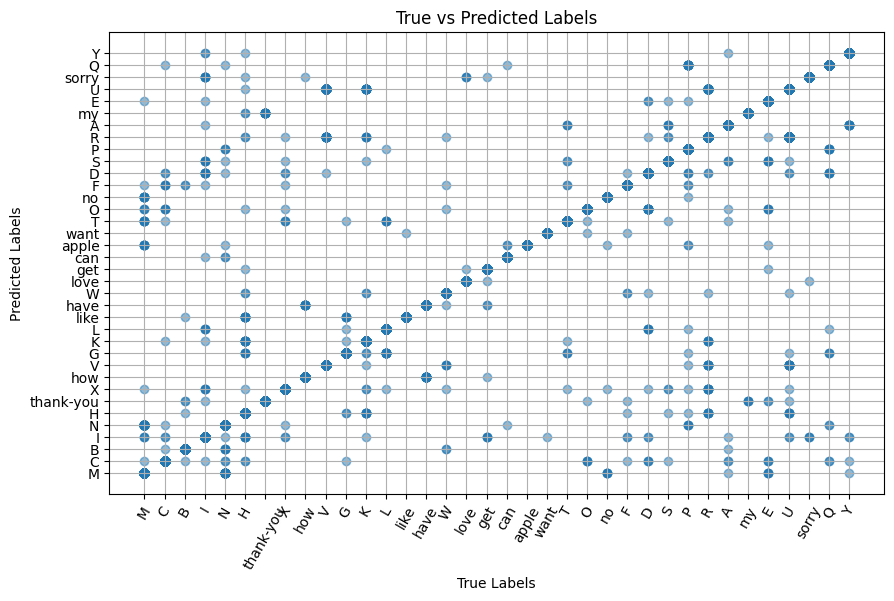

In [29]:
visualize_predictions(model, x_test, y_test)